<a href="https://colab.research.google.com/github/frosinastojanovska/predoc-course-2020/blob/main/nuclei_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To work with the notebook, the Drive needs to be mounted. Additionally, there should be a folder named qbm_data with the following structure:


*   qbm_module
*   |----raw - sub-folder containing dataset h5 files with the channels
*   |----classification - sub-folder (at the begining empty) that contains the preprocesed data for the ML pipeline into pkl files






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Creating dataset for training and testing

###Processing of the dataset into bounding boxes

In [ ]:
#Create cell bonding boxes and gt labels
import h5py
import os
import numpy as np
import pickle as pkl
from skimage.measure import regionprops

filenames = [filename for filename in os.listdir('/content/drive/MyDrive/qbm_data/raw') if filename.endswith(".h5")]

for filename in filenames:
    with h5py.File('/content/drive/MyDrive/qbm_data/raw/' + filename, "r") as f:
        data = {}
        cells_segmented = f.get('cells').value
        serum = f.get('raw')[0,::]
        nuclei_infection = f.get('infected').value
        properties = regionprops(cells_segmented)
        
        for i, elem in enumerate(properties):
            minr, minc, maxr, maxc = elem.bbox
            cs = cells_segmented[minr:maxr,minc:maxc].copy()
            gt = nuclei_infection[minr:maxr,minc:maxc].copy()
            sr = serum[minr:maxr,minc:maxc].copy()
            # Mask the backroung which is not the current cell (neighbouring cells)
            gt[cs != elem.label] = 0
            sr[cs != elem.label] = 0
            cs[cs != elem.label] = 0
            # Check if the mask contains true and negative class and try to fix this
            if len(np.unique(gt).tolist()) == 3:
                # The following commented code visualize when we have some artifacts into the data
                # import matplotlib.pyplot as plt
                # import matplotlib.patches as patches
                # import numpy as np
                # # Create figure and axes
                # fig,ax = plt.subplots(1)
                # # Display the image
                # ax.imshow(gt, cmap='gray')
                # plt.show()

                # if come of the class is occuring more than 90% of the labels, then that is considered as
                # gt class
                if np.count_nonzero(gt == 1) > 0.9 * (np.count_nonzero(gt == 1) + np.count_nonzero(gt == 2)):
                    label = 1
                elif np.count_nonzero(gt == 2) > 0.9 * (np.count_nonzero(gt == 1) + np.count_nonzero(gt == 2)):
                    label = 2
                else:
                  # if one of the classes is not occuring more than 90% of the classes, we ignore
                  # the data sample (cell)
                  continue
            else:
                label = np.max(gt)
            cs[cs != 0] = 1
            # save the processed data into a dictionary 
            data[i] = {'cell_seg': cs, 'label': label, 'serum': sr, 'bbox': (minr, minc, maxr, maxc), 'cell_label': elem.label}
    with open('/content/drive/MyDrive/qbm_data/classification/' + filename.split('.h5')[0] + '.pkl', "wb") as f_out:
        pkl.dump(data, f_out)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  from ipykernel import kernelapp as app


###Visualization

Visualization of the bounding boxes over the original image (serum channel)

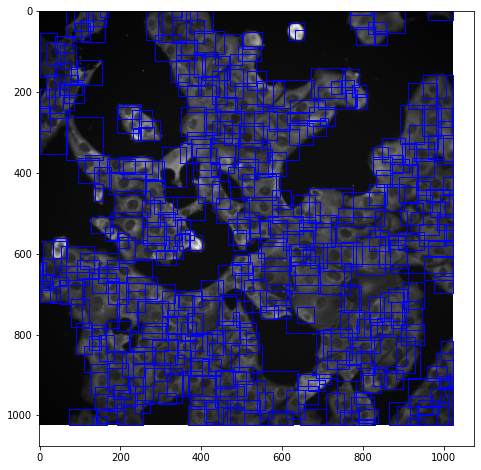

387
386


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Create figure and axes
plt.figure(figsize=(8,8))

# Display the image
plt.imshow(serum, cmap='gray')

for elem in properties:
    # Create a Rectangle patch
    minr, minc, maxr, maxc = elem.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    plt.plot(bx, by, '-b', linewidth=1)

plt.show()
print(len(np.unique(cells_segmented)))
print(len(properties))

#Visualization of the bounding boxes areas

[22, 33, 51, 20, 43, 63, 84, 33, 15, 13, 60, 60, 35, 112, 30, 27, 50, 55, 4, 45, 61, 50, 48, 81, 45, 64, 48, 63, 98, 29, 44, 59, 76, 29, 88, 49, 83, 59, 87, 75, 79, 88, 77, 48, 71, 63, 51, 83, 68, 80, 52, 61, 48, 40, 37, 53, 58, 47, 68, 59, 70, 116, 91, 101, 35, 53, 42, 95, 54, 61, 43, 48, 67, 51, 52, 57, 57, 47, 62, 75, 57, 7, 54, 93, 52, 65, 48, 84, 47, 43, 52, 55, 120, 48, 48, 44, 74, 40, 41, 49, 56, 86, 73, 48, 13, 44, 58, 38, 52, 84, 72, 81, 56, 62, 56, 48, 48, 91, 43, 40, 39, 71, 101, 51, 49, 53, 45, 43, 68, 102, 79, 40, 88, 76, 49, 67, 47, 65, 65, 53, 49, 49, 79, 55, 86, 82, 56, 62, 71, 43, 64, 43, 76, 35, 73, 34, 45, 111, 46, 49, 70, 99, 52, 56, 84, 18, 25, 53, 50, 49, 12, 74, 44, 67, 67, 41, 24, 72, 74, 74, 82, 69, 60, 102, 52, 47, 62, 49, 71, 54, 32, 46, 52, 64, 69, 42, 71, 52, 56, 49, 63, 75, 51, 44, 46, 81, 41, 67, 59, 31, 44, 67, 57, 25, 38, 52, 45, 69, 29, 49, 9, 64, 28, 44, 72, 51, 48, 42, 55, 74, 64, 55, 27, 35, 54, 46, 43, 74, 55, 64, 52, 55, 125, 51, 96, 44, 53, 28, 6

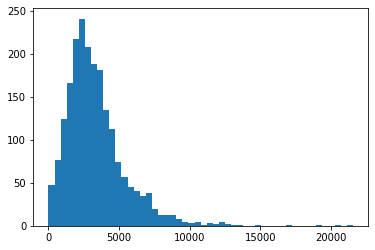

In [ ]:
import pickle
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

width, length, area = [], [], []
filenames = [filename for filename in os.listdir('/content/drive/MyDrive/qbm_data/classification') if filename.endswith(".pkl") and not filename.startswith('WellE05')]
for filename in filenames:
    with open('/content/drive/MyDrive/qbm_data/classification/'+filename, 'rb') as f:
        gt_data = pickle.load(f)
        for key in gt_data.keys():
            data = gt_data[key]
            cs = data['cell_seg']
            minr, minc, maxr, maxc = data['bbox']
            width.append(maxc-minc)
            length.append(maxr-minr)
            area.append((maxc-minc)*(maxr-minr))
print (width)
print (length)
print (area)
print (max(area))
print (min(area))
print (sum(area)/len(area))
plt.hist(area, bins = 50)
plt.show()

#Cell classification with intensity score

The thresholding classification with the intensity score was performed into Fiji, where the thresholded binary map was saved as tiff file

## Testing the values of the metrics for the test image

In [61]:
import pickle
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score

im = Image.open('/content/drive/MyDrive/qbm_data/classification/WellE05_PointE05_Threshold.tif')
cell_seg = np.array(im)
tp, fp, tn, fn = 0, 0, 0, 0

maps = {}
with open('/content/drive/MyDrive/qbm_data/classification/WellE05_PointE05_0004_ChannelDAPI,WF_GFP,TRITC,WF_Cy5,DIA_Seq0454.pkl', 'rb') as f:
    gt_data = pickle.load(f)
    for key in gt_data.keys():
        data = gt_data[key]
        cs = data['cell_seg']
        minr, minc, maxr, maxc = data['bbox']
        label = data['label']
        roi = cell_seg[minr:maxr,minc:maxc].copy()
        roi[cs == 0] = 0

        # Ignore cell bboxes that are too small or too big
        a, b = roi.shape
        if a * b < 400:
            continue
        if a * b > 10000:
            continue
        
        # if there is part of the threshold mask into the roi, then this is 
        # infected cell, else non-infected cell
        if np.max(roi) > 0:
            pred_label = 1
        else:
            pred_label = 2
        
        cell_label = data['cell_label']
        maps[cell_label] = 1 if label == pred_label else 2
        
        if label == 1:
            if pred_label == label:
                tp += 1
            else:
                fn += 1
        else:
            if pred_label == label:
                tn += 1
            else:
                fp += 1
    print('Accuracy:', (tp+tn)/(tp+tn+fp+fn))
    precision = tp / (tp+fp)
    print('Precision:', precision)
    recall = tp / (tp + fn)
    print('Recall:', recall)
    print('F1 measure:', (2 * recall * precision) / (recall + precision))

with open('/content/drive/MyDrive/qbm_data/classification/thresh_result_labels.pkl', "wb") as f_out:
    pkl.dump(maps, f_out)

Accuracy: 0.7735849056603774
Precision: 0.9354838709677419
Recall: 0.7435897435897436
F1 measure: 0.8285714285714285


###Visualization of the predictions

Blues are true predicted cells, and red is false predicted cells

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # This is added back by InteractiveShellApp.init_path()


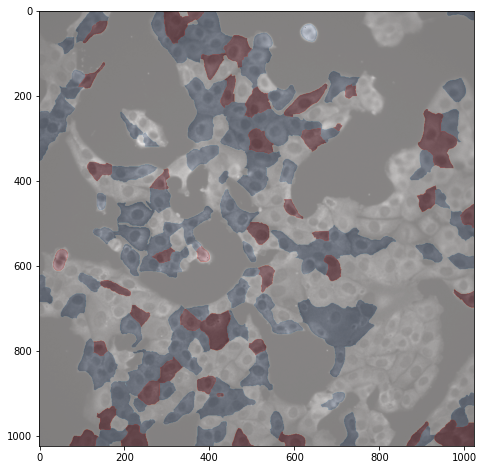

In [64]:
import matplotlib.pyplot as plt
import os
import pickle as pkl

with open('/content/drive/MyDrive/qbm_data/classification/thresh_result_labels.pkl', "rb") as f:
    datas = pkl.load(f)

with open('/content/drive/MyDrive/qbm_data/classification/WellE05_PointE05_0004_ChannelDAPI,WF_GFP,TRITC,WF_Cy5,DIA_Seq0454.pkl', 'rb') as f:
  with h5py.File('/content/drive/MyDrive/qbm_data/raw/' + filename, "r") as f:
        serum_image = f.get('raw').value[0,:,:]
        cell_image = f.get('cells').value
        cell_image_true_pred = cell_image.copy()
        cell_image_false_pred = cell_image.copy()
        for key in datas.keys():
            cell_image_true_pred[cell_image == key] = datas[key] % 2
            cell_image_false_pred[cell_image == key] = (datas[key] + 1) % 2

cell_image_true_pred[cell_image_true_pred > 1] = 0
cell_image_false_pred[cell_image_false_pred > 1] = 0

plt.figure(figsize=(8,8))
plt.imshow(serum_image, cmap='gray')
plt.imshow(cell_image_true_pred, cmap='Blues', alpha=0.3)
plt.imshow(cell_image_false_pred, cmap='Reds', alpha=0.3)
plt.show()

#Cell classification with ML (DL)

In [ ]:
import scipy
import numpy as np
from scipy import ndimage

# Code adapted from Keras library
def apply_affine_transform(x, theta=0, row_axis=0, col_axis=1, channel_axis=2,
                           fill_mode='nearest', cval=0., order=1):
    """Applies an affine transformation specified by the parameters given.
    # Arguments
        x: 3D numpy array - a 2D image with one or more channels.
        theta: Rotation angle in degrees.
        row_axis: Index of axis for rows (aka Y axis) in the input image.
                  Direction: left to right.
        col_axis: Index of axis for columns (aka X axis) in the input image.
                  Direction: top to bottom.
        channel_axis: Index of axis for channels in the input image.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
        order: int, order of interpolation
    # Returns
        The transformed version of the input.
    """
    if scipy is None:
        raise ImportError('Image transformations require SciPy. '
                          'Install SciPy.')

    # Input sanity checks:
    # 1. x must 2D image with one or more channels (i.e., a 3D tensor)
    # 2. channels must be either first or last dimension
    if np.unique([row_axis, col_axis, channel_axis]).size != 3:
        raise ValueError("'row_axis', 'col_axis', and 'channel_axis'"
                         " must be distinct")

    # TODO: shall we support negative indices?
    valid_indices = set([0, 1, 2])
    actual_indices = set([row_axis, col_axis, channel_axis])
    if actual_indices != valid_indices:
        raise ValueError(
            f"Invalid axis' indices: {actual_indices - valid_indices}")

    if x.ndim != 3:
        raise ValueError("Input arrays must be multi-channel 2D images.")
    if channel_axis not in [0, 2]:
        raise ValueError("Channels are allowed and the first and last dimensions.")

    transform_matrix = None
    if theta != 0:
        theta = np.deg2rad(theta)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                    [np.sin(theta), np.cos(theta), 0],
                                    [0, 0, 1]])
        transform_matrix = rotation_matrix

    if transform_matrix is not None:
        h, w = x.shape[row_axis], x.shape[col_axis]
        transform_matrix = transform_matrix_offset_center(
            transform_matrix, h, w)
        x = np.rollaxis(x, channel_axis, 0)

        # Matrix construction assumes that coordinates are x, y (in that order).
        # However, regular numpy arrays use y,x (aka i,j) indexing.
        # Possible solution is:
        #   1. Swap the x and y axes.
        #   2. Apply transform.
        #   3. Swap the x and y axes again to restore image-like data ordering.
        # Mathematically, it is equivalent to the following transformation:
        # M' = PMP, where P is the permutation matrix, M is the original
        # transformation matrix.
        if col_axis > row_axis:
            transform_matrix[:, [0, 1]] = transform_matrix[:, [1, 0]]
            transform_matrix[[0, 1]] = transform_matrix[[1, 0]]
        final_affine_matrix = transform_matrix[:2, :2]
        final_offset = transform_matrix[:2, 2]

        channel_images = [ndimage.interpolation.affine_transform(
            x_channel,
            final_affine_matrix,
            final_offset,
            order=order,
            mode=fill_mode,
            cval=cval) for x_channel in x]
        x = np.stack(channel_images, axis=0)
        x = np.rollaxis(x, 0, channel_axis + 1)
    return x

def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 - 0.5
    o_y = float(y) / 2 - 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

### Create class for data generation for training the model

In [ ]:
import os
import cv2
import numpy as np

class Config:
    NAME = 'deep_cell_detection'

    # NUMBER OF GPUs to use. For CPU training, use 1
    GPU_COUNT = 1

    # Weight decay regularization
    WEIGHT_DECAY = 0.0001

    def __init__(self, padding_size=(50,50), batch_size=1):
        self.PADDING_SIZE = padding_size
        self.BATCH_SIZE = batch_size


def data_generator(filenames, config, aug):
    """ A generator that returns cells and corresponding target classes.
    """
    b = 0  # batch item index
    image_index = -1
    batch_input_cell = []
    batch_labels = []

    # Keras requires a generator to run indefinitely.
    while True:
        try:
            # Increment index to pick next filename. Shuffle if at the start of an epoch.
            image_index = (image_index + 1) % len(filenames)

            # Get cell images and GT classes.
            image_name = filenames[image_index]
            with open('/content/drive/MyDrive/qbm_data/classification/' + image_name, 'rb') as f:
                gt_data = pickle.load(f)
                for key in gt_data.keys():
                    data = gt_data[key]
                    cell_image = data['serum']
                    label = data['label'] % 2
                    a, b = cell_image.shape
                    if a * b < 400:
                        continue
                    if a * b > 10000:
                        continue
                    # padding / resizing
                    resized_img = cv2.resize(cell_image, config.PADDING_SIZE, cv2.INTER_AREA)
                    resized_img = resized_img[:,:,np.newaxis]
                    # normalize from 0 to 1
                    resized_img = cv2.normalize(resized_img, resized_img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)


                    # Data augumentation
                    if aug:
                        # rotation
                        theta = np.random.uniform(-90, 90)
                        # flip
                        flip_horizontal = (np.random.random() < 0.5) * True
                        flip_vertical = (np.random.random() < 0.5) * True
                        # # brightness
                        # brightness = np.random.uniform(0.2,1.0)

                        resized_img = apply_affine_transform(resized_img, theta=theta)

                        if flip_horizontal:
                            resized_img = flip_axis(resized_img, 1)
                        elif flip_vertical:
                            resized_img = flip_axis(resized_img, 0)
                        else:
                            resized_img = resized_img


                    
                    # Add to batch
                    batch_input_cell.append(resized_img)
                    batch_labels.append([label])
                    b += 1

                    # Batch full?
                    if b >= config.BATCH_SIZE:
                        batch_input_cell = np.array(batch_input_cell)
                        batch_labels = np.array(batch_labels)
                        yield batch_input_cell, batch_labels
                        # start a new batch
                        b = 0
                        batch_input_cell = []
                        batch_labels = []
        except (GeneratorExit, KeyboardInterrupt):
            print('yeiii')
            raise

###Creating the DL keras model 

In [ ]:
import keras.layers as KL
import pickle
import keras as K
import tensorflow as tf
import keras.models as KM

def cnn_model(config):
    """
        CNN model
    """
    x = KL.Input(shape=(50, 50, 1), name='input')
    cnn1 = KL.Conv2D(6, 3)(x)
    cnn1 = KL.BatchNormalization()(cnn1)
    cnn1_a = KL.ReLU()(cnn1)
    cnn2 = KL.Conv2D(12, 5)(cnn1_a)
    cnn2 = KL.BatchNormalization()(cnn2)
    cnn2_a = KL.ReLU()(cnn2)
    polled = KL.AveragePooling2D()(cnn2_a)
    polled = KL.Flatten()(polled)
    polled = KL.Dense(64, activation='relu')(polled)
    polled = KL.Dense(32, activation='relu')(polled)
    polled = KL.Dense(1, activation='sigmoid')(polled)

    model = KM.Model(x, polled, name='deep_cell_classification')


    return model

###Train the network

In [ ]:
import os
import keras

config = Config(batch_size=1)
filenames = [filename for filename in os.listdir('/content/drive/MyDrive/qbm_data/classification') if filename.endswith(".pkl") and not filename.startswith('WellE05')]


model = cnn_model(config)
model.build((50, 50, 1))
opt = keras.optimizers.Adam(lr=0.001, amsgrad=True)
model.compile(optimizer=opt, loss=keras.losses.binary_crossentropy)

train_data_generator = data_generator(filenames[:-1], config, aug=True)
val_data_generator = data_generator(filenames[-1:], config, aug=False)

model_filepath = '/content/drive/MyDrive/qbm_data/trained/deep_model-{epoch:02d}.h5'
logs_filepath = '/content/drive/MyDrive/qbm_data/trained/deepmodel.log'

if not os.path.exists(os.path.dirname(logs_filepath)):
    os.makedirs(os.path.dirname(logs_filepath))

checkpoint = keras.callbacks.ModelCheckpoint(model_filepath, verbose=1, save_weights_only=True, mode='min')
csv_logger = keras.callbacks.CSVLogger(logs_filepath)
print(model.summary())

model.fit_generator(train_data_generator, epochs=150, steps_per_epoch=100,
                    callbacks=[checkpoint, csv_logger], validation_data=val_data_generator,
                    validation_steps=365//config.BATCH_SIZE, verbose=1)

Model: "deep_cell_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 50, 50, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 6)         60        
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 48, 6)         24        
_________________________________________________________________
re_lu_8 (ReLU)               (None, 48, 48, 6)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 44, 44, 12)        1812      
_________________________________________________________________
batch_normalization_9 (Batch (None, 44, 44, 12)        48        
_________________________________________________________________
re_lu_9 (ReLU)               (None, 44, 44

####Visualize the learning curves

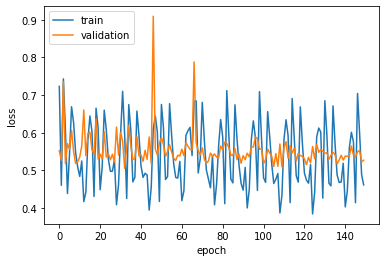

In [65]:
import matplotlib.pyplot as plt

with open('/content/drive/MyDrive/qbm_data/trained/deepmodel.log', 'r') as f:
      _ = f.readline().strip()
      line = f.readline().strip()
      epochs = []
      train_losses = []
      val_losses = []

      while line != '':
          epoch, train_loss, val_loss = line.split(',')
          epochs.append(int(epoch))
          train_losses.append(float(train_loss))
          val_losses.append(float(val_loss))
          line = f.readline().strip()

      epochs = np.array(epochs)
      train_losses = np.array(train_losses)
      val_losses = np.array(val_losses)

      plt.plot(epochs, train_losses)
      plt.plot(epochs, val_losses)
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train', 'validation'], loc='upper left')
      plt.show()

##Test the network

In [ ]:
import pickle
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score

config = Config(batch_size=1)
model = cnn_model(config)
model.load_weights('/content/drive/MyDrive/qbm_data/trained/deep_model-150.h5')

tp, fp, tn, fn = 0, 0, 0, 0
maps = {}

with open('/content/drive/MyDrive/qbm_data/classification/WellE05_PointE05_0004_ChannelDAPI,WF_GFP,TRITC,WF_Cy5,DIA_Seq0454.pkl', 'rb') as f:
    gt_data = pickle.load(f)
    for key in gt_data.keys():
        data = gt_data[key]
        cell_image = data['serum']
        label = data['label'] % 2
        a, b = cell_image.shape
        if a * b < 400:
            continue
        if a * b > 10000:
            continue
        
        # padding / resizing
        resized_img = cv2.resize(cell_image, config.PADDING_SIZE, cv2.INTER_AREA)
        resized_img = resized_img[:,:,np.newaxis]
        # normalize from 0 to 1
        resized_img = cv2.normalize(resized_img, resized_img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        pred_label = model.predict(np.array([resized_img]))[0][0]
        pred_label = 1 if pred_label > 0.7 else 0
        label = data['label'] % 2

        cell_label = data['cell_label']
        maps[cell_label] = 1 if label == pred_label else 2
        
        if label == 1:
            if pred_label == label:
                tp += 1
            else:
                fn += 1
        else:
            if pred_label == label:
                tn += 1
            else:
                fp += 1
    print('Accuracy:', (tp+tn)/(tp+tn+fp+fn))
    precision = tp / (tp+fp)
    print('Precision:', precision)
    recall = tp / (tp + fn)
    print('Recall:', recall)
    print('F1 measure:', (2 * recall * precision) / (recall + precision))

with open('/content/drive/MyDrive/qbm_data/classification/dl_result_labels.pkl', "wb") as f_out:
    pkl.dump(maps, f_out)

Accuracy: 0.7412398921832885
Precision: 0.743801652892562
Recall: 0.989010989010989
F1 measure: 0.8490566037735849


###Visualization of the predictions

Blues are true predicted cells, and red is false predicted cells

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # This is added back by InteractiveShellApp.init_path()


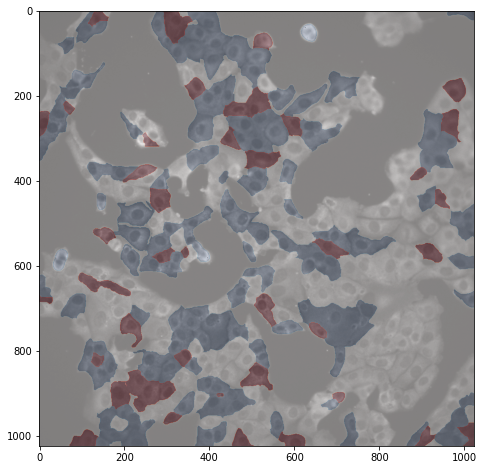

In [63]:
import matplotlib.pyplot as plt
import os
import pickle as pkl

with open('/content/drive/MyDrive/qbm_data/classification/dl_result_labels.pkl', "rb") as f:
    datas = pkl.load(f)

with open('/content/drive/MyDrive/qbm_data/classification/WellE05_PointE05_0004_ChannelDAPI,WF_GFP,TRITC,WF_Cy5,DIA_Seq0454.pkl', 'rb') as f:
  with h5py.File('/content/drive/MyDrive/qbm_data/raw/' + filename, "r") as f:
        serum_image = f.get('raw').value[0,:,:]
        cell_image = f.get('cells').value
        cell_image_true_pred = cell_image.copy()
        cell_image_false_pred = cell_image.copy()
        for key in datas.keys():
            cell_image_true_pred[cell_image == key] = datas[key] % 2
            cell_image_false_pred[cell_image == key] = (datas[key] + 1) % 2

cell_image_true_pred[cell_image_true_pred > 1] = 0
cell_image_false_pred[cell_image_false_pred > 1] = 0

plt.figure(figsize=(8,8))
plt.imshow(serum_image, cmap='gray')
plt.imshow(cell_image_true_pred, cmap='Blues', alpha=0.3)
plt.imshow(cell_image_false_pred, cmap='Reds', alpha=0.3)
plt.show()